# **Computer Vision Project - Feasability** 
## **Brain Tumor Classification**

Link to dataset: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

Goal: Supervised Classification

----

#### **Initial Look**
- The dataset already has 4 classes (glioma, meningioma, pituitary, no_tumor)
- Total of 7027 mri images in grayscale
- Number of images in **Training**:
  - pituitary: 1457 images
  - notumor: 1595 images
  - glioma: 1321 images
  - meningioma: 1339 images
- Number of images in **Testing**:
  - pituitary: 301 image
  - notumor: 406 images
  - glioma: 301 images
  - meningioma: 307 images

In [34]:
# import libraries
import os
import numpy as np
import keras
import shutil
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# for data loading in Keras
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image, ImageOps
import cv2
from tqdm import tqdm
import imutils
import json

In [3]:
# look at data and classes
data_dir = 'tumor_data'
train_dir = os.path.join(data_dir, 'Training')
test_dir = os.path.join(data_dir, 'Testing')

print("Classes in Training:", os.listdir(train_dir))
print("Classes in Testing:", os.listdir(test_dir))

Classes in Training: ['pituitary', 'notumor', 'glioma', 'meningioma']
Classes in Testing: ['pituitary', '.DS_Store', 'notumor', 'glioma', 'meningioma']


In [5]:
# checking the number of images
# training
for cls in os.listdir(train_dir):
    n_images = len(os.listdir(os.path.join(train_dir, cls)))
    print(f"{cls}: {n_images} images")

pituitary: 1457 images
notumor: 1595 images
glioma: 1321 images
meningioma: 1339 images


In [7]:
# checking the number of images
# testing 

for cls in os.listdir(test_dir):
    cls_path = os.path.join(test_dir, cls)
    if os.path.isdir(cls_path):  # check if its a directory
        n_images = len(os.listdir(cls_path))
        print(f"{cls}: {n_images} images")
    else:
        print(f"{cls} is not a directory and will be skipped.")
        
'''
for cls in os.listdir(test_dir):
    n_images = len(os.listdir(os.path.join(test_dir, cls)))
    print(f"{cls}: {n_images} images")
'''

pituitary: 301 images
.DS_Store is not a directory and will be skipped.
notumor: 406 images
glioma: 301 images
meningioma: 307 images


'\nfor cls in os.listdir(test_dir):\n    n_images = len(os.listdir(os.path.join(test_dir, cls)))\n    print(f"{cls}: {n_images} images")\n'

In [9]:
# filtering out corrupted images
# function using Python Imaging Library (PIL) to look at images bc safer and more general than just checking for JPEG headers (JPEG, PNG, BMP, etc.)

def check_corrupt_images(directory):
    # loop over ea. class folder
    for cls in os.listdir(directory):
        cls_path = os.path.join(directory, cls)
        if not os.path.isdir(cls_path):
            continue  # had a .DS_Store file so this will skip it!!!
        
        # loop over ea. image 
        for img_name in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_name)

            if os.path.isdir(img_path): # this also skip subfolders like .ipynb_checkpoints
                continue
                
            try:
                # to open the image to verify if not corrupt
                with Image.open(img_path) as img:
                    img.verify() 
            except Exception as e:
                # if error, remove
                print(f"Remove corrupt image: {img_path}")
                os.remove(img_path)


check_corrupt_images(os.path.join(data_dir, 'Training'))
check_corrupt_images(os.path.join(data_dir, 'Testing'))

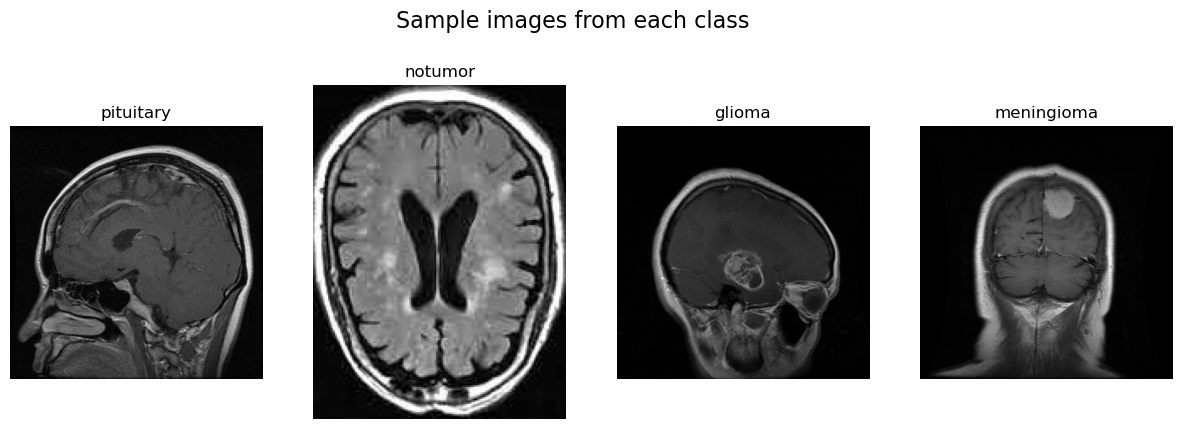

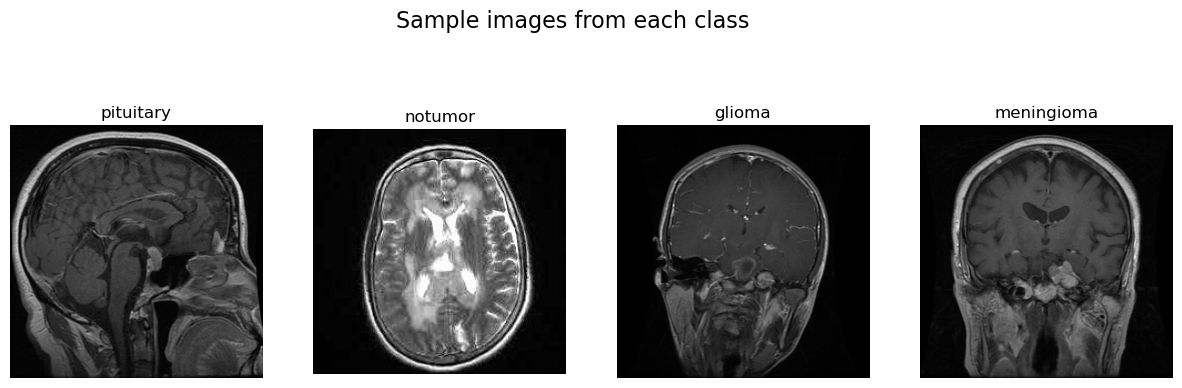

In [11]:
# visualizing some images 

def sample_images(directory, num_classes=4):
    class_names = os.listdir(directory)
    class_names = [cls for cls in class_names if os.path.isdir(os.path.join(directory, cls))]
    
    plt.figure(figsize=(15, 5))
    
    for i, cls in enumerate(class_names[:num_classes]):
        cls_folder = os.path.join(directory, cls)
        image_files = os.listdir(cls_folder)
        
        # skip hidden files
        image_files = [img for img in image_files if not img.startswith('.')]
        
        img_file = random.choice(image_files)
        img_path = os.path.join(cls_folder, img_file)
        img = mpimg.imread(img_path)
        
        plt.subplot(1, num_classes, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(cls)
        plt.axis('off')
    
    plt.suptitle("Sample images from each class", fontsize=16)
    plt.show()

sample_images(os.path.join(data_dir, 'Training'))
sample_images(os.path.join(data_dir, 'Testing'))

In [13]:
# looking at image shapes and types
img_path = os.path.join(data_dir, 'Training', 'glioma', os.listdir(os.path.join(data_dir, 'Training', 'glioma'))[0])
img = Image.open(img_path)
img_array = np.array(img)

print("Image shape:", img_array.shape)
print("Image mode:", img.mode)

Image shape: (512, 512)
Image mode: L


**Notes:**
- L is a grayscale
- Consider cropping out black margins to improve accuracy
- Dataset description on kaggle mentioned size of all the images are different
------

#### Do some cleaning: 

In [16]:
# crop out black margins (from link provided by dataset)

def crop_img(img):

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    # threshold the image, then perform a series of erosions +
	# dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    if not cnts:
        return img

    # find the extreme points
    c = max(cnts, key=cv2.contourArea)
    extLeft  = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop   = tuple(c[c[:, :, 1].argmin()][0])
    extBot   = tuple(c[c[:, :, 1].argmax()][0])
    
    return img[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

In [18]:
# function to crop and save 
def preprocess_save_grayscale(source_dir, target_dir, img_size=(224, 224)):
    # making a target directory
    os.makedirs(target_dir, exist_ok=True)
    
    # classes 
    for cls in tqdm(os.listdir(source_dir), desc=f"Preprocessing {source_dir}"):
        cls_path = os.path.join(source_dir, cls)  
        
        if not os.path.isdir(cls_path):
            continue
        
        # making a corresponding directory in the target location for the class
        save_cls_path = os.path.join(target_dir, cls)
        os.makedirs(save_cls_path, exist_ok=True)
        
        # go through the images now
        for img_name in os.listdir(cls_path):
            if img_name.startswith('.'):
                continue
            
            img_path = os.path.join(cls_path, img_name)  # path to image file
            
            try:
                # keep in grayscale 
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                
                # make sure if it was read
                if img is None:
                    print(f"Warning: Could not read {img_path}")
                    continue
                
                # crop the image
                merged_img = cv2.merge([img, img, img])  # make 3-channel image from the grayscale
                cropped = crop_img(cv2.cvtColor(merged_img, cv2.COLOR_BGR2RGB))  # convert to rgb for cropping
                
                # convert back to grayscale
                cropped_gray = cv2.cvtColor(cropped, cv2.COLOR_RGB2GRAY)
                
                # resize image 
                resized = cv2.resize(cropped_gray, img_size)
                
                # save path for the image
                save_path = os.path.join(save_cls_path, img_name)
                
                cv2.imwrite(save_path, resized)
            except Exception as e:
                print(f"Failed to process {img_path}: {e}")

In [20]:
# cleaned dataset folders
clean_train_dir = 'tumor_data_cleaned/Training'
clean_test_dir = 'tumor_data_cleaned/Testing'

In [26]:
'''
# running preprocessing 
preprocess_save_grayscale(train_dir, clean_train_dir)
preprocess_save_grayscale(test_dir, clean_test_dir)
'''

'\n# running preprocessing \npreprocess_save_grayscale(train_dir, clean_train_dir)\npreprocess_save_grayscale(test_dir, clean_test_dir)\n'

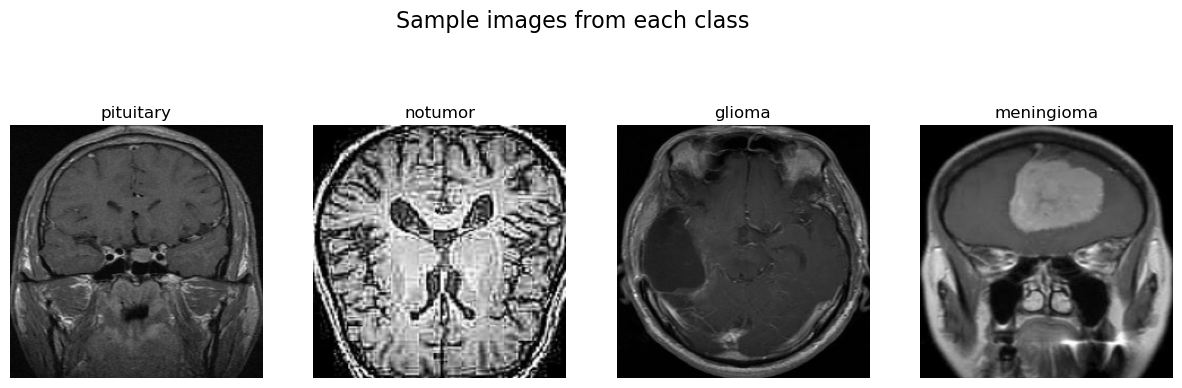

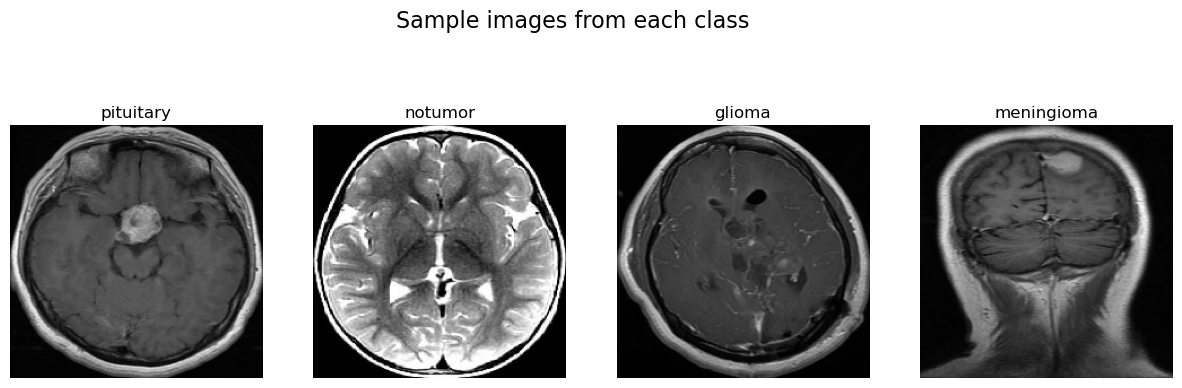

In [24]:
# check work
sample_images(clean_train_dir)
sample_images(clean_test_dir)

In [28]:
img_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# a data generator for training images
train_gen = datagen.flow_from_directory(
    clean_train_dir,  
    target_size=img_size,  # resize all images 
    color_mode='grayscale', 
    batch_size= batch_size,  
    class_mode='categorical',  
    subset='training',  
    shuffle=True,  # shuffle data at each epoch to improve training
    seed=42  # seed for random number generator 
)

# a data generator for validation images
val_gen = datagen.flow_from_directory(
    clean_train_dir,  
    target_size= img_size,  
    color_mode='grayscale',  
    batch_size= batch_size,  
    class_mode='categorical',  
    subset='validation',  
    shuffle=True,  
    seed=42  
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


Batch image shape: (32, 224, 224, 1)
Batch labels shape: (32, 4)


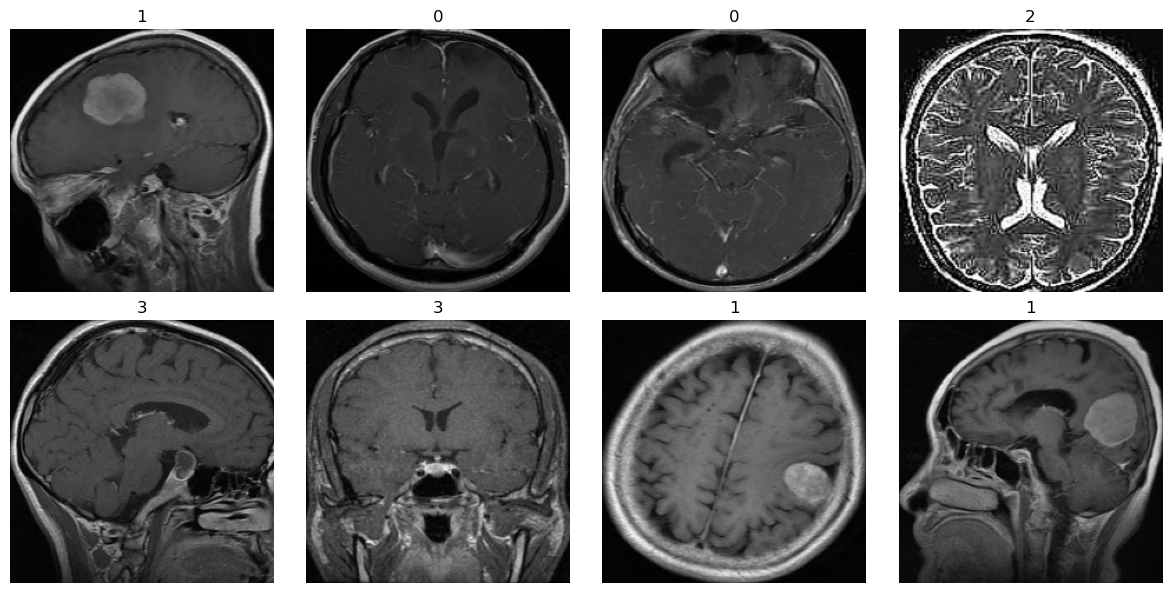

In [30]:
# visualizing the batch 
imgs, labels = next(train_gen)

print("Batch image shape:", imgs.shape)  
print("Batch labels shape:", labels.shape)  

plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')  
    plt.title(np.argmax(labels[i]))
    plt.axis('off')
plt.tight_layout()
plt.show()

In [32]:
# look at the mapping
print("Class indices:", train_gen.class_indices)

Class indices: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [36]:
# saving class indices for reuse later 

with open('class_indices.json', 'w') as f:
    json.dump(train_gen.class_indices, f)

print("Class indices saved to class_indices.json")

Class indices saved to class_indices.json
